# Binary Prediction of Poisonous Mushrooms 🍄🚫

<img src="https://cdn.mos.cms.futurecdn.net/2LyKpgmMvXc3QKr7QboJHj-1200-80.jpg">

## Introduction

In this notebook, we tackle the challenge of predicting whether mushrooms are poisonous or edible. This task is part of the Kaggle Tabular Playground Series, which is designed to help data scientists and machine learning practitioners refine their skills using synthetic datasets.

## Problem Statement

The objective is to classify mushrooms into two categories:
- **Edible**: Safe to eat.
- **Poisonous**: Potentially harmful or toxic.

The dataset provided for this competition is generated from a deep learning model trained on the UCI Mushroom dataset. While the feature distributions are similar to the original dataset, there may be some variations. The challenge lies in effectively using this synthetic data to build a predictive model.

## Dataset

The dataset consists of the following:
- **Training Data**: Used to train the machine learning models.
- **Test Data**: Used to evaluate the model performance.

The features in the dataset represent various attributes of mushrooms, which are utilized to make predictions about their edibility.

## Approach

To solve the problem, we will follow these steps:
1. **Data Preparation**: Load and preprocess the data.
2. **Model Training**: Train machine learning models using the training data.
3. **Model Evaluation**: Evaluate the performance of the models using appropriate metrics.
4. **Prediction**: Generate predictions for the test set.
5. **Visualization**: Analyze the results and visualize the distribution of predictions.

## Goals

- Develop a robust model that can accurately classify mushrooms as edible or poisonous.
- Optimize model performance to achieve the highest possible accuracy and MCC (Matthews Correlation Coefficient).

By leveraging various machine learning techniques and evaluation strategies, we aim to enhance the predictive power of our models and provide reliable predictions for mushroom edibility.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Part 1: Import Libraries and Suppress Warnings

In [2]:
import warnings

# Suppress all warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder
from scipy.sparse import hstack
from sklearn.metrics import matthews_corrcoef, make_scorer
from scipy.stats import randint, uniform
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Part 2: Load Data and Initial Exploration

In [3]:
XTrain = pd.read_csv("train.csv")
CompTest = pd.read_csv("test.csv")

# Quick overview of the data
print(XTrain.head())
print(XTrain.info())

   id class  cap-diameter cap-shape cap-surface cap-color  \
0   0     e          8.80         f           s         u   
1   1     p          4.51         x           h         o   
2   2     e          6.94         f           s         b   
3   3     e          3.88         f           y         g   
4   4     e          5.85         x           l         w   

  does-bruise-or-bleed gill-attachment gill-spacing gill-color  ...  \
0                    f               a            c          w  ...   
1                    f               a            c          n  ...   
2                    f               x            c          w  ...   
3                    f               s          NaN          g  ...   
4                    f               d          NaN          w  ...   

   stem-root  stem-surface stem-color veil-type veil-color has-ring ring-type  \
0        NaN           NaN          w       NaN        NaN        f         f   
1        NaN             y          o       

# Visualization 1: Distribution of the Target Variable

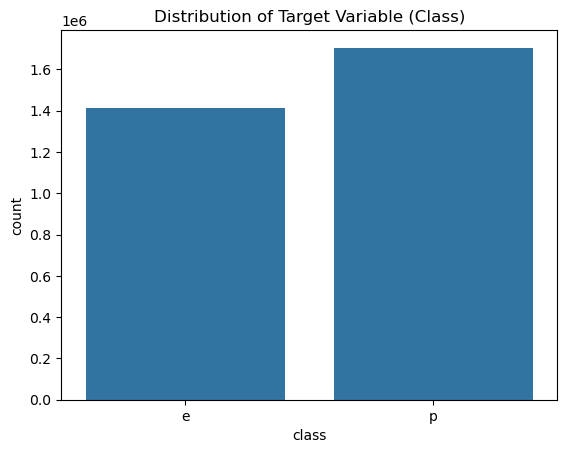

In [4]:
sns.countplot(x='class', data=XTrain)
plt.title("Distribution of Target Variable (Class)")
plt.show()

# Part 3: Data Cleaning and Outlier Handling

In [4]:
# Define Numeric and Cat Columns
NumericCols = ['cap-diameter', 'stem-height', 'stem-width']
CategoricalCols = ["cap-shape","cap-surface","cap-color","does-bruise-or-bleed","gill-spacing",
                   "gill-color","stem-root","stem-surface","stem-color","veil-type","has-ring",
                   "ring-type","spore-print-color","habitat","season","gill-attachment","veil-color"]

#### Data Clean Algorithm #################################
def DataClean(Data):
    for i in NumericCols:
        if Data[i].isna().sum() != 0:
            X = Data[i].median()
            Data[i].fillna(value = X, inplace=True)
            
            # Using IQR method to remove outliers
            Q1 = Data[i].quantile(0.25)
            Q3 = Data[i].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            Data[i] = Data[i].apply(lambda x: lower_bound if x < lower_bound else x)
            Data[i] = Data[i].apply(lambda x: upper_bound if x > upper_bound else x)
    
    for j in CategoricalCols:
        if Data[j].isna().sum() != 0:
            X = Data[j].mode(dropna=True)[0]
            Data[j].fillna(value = "noise", inplace=True)
        
        else:
            threshold = 100
            # Identify the values that occur less than the threshold
            counts = Data[j].value_counts()
            rare_values = counts[counts < threshold].index
            # Replace rare values with 'noise'
            Data[j] = Data[j].replace(rare_values, 'noise')
            # Convert to categorical
            Data[j] = Data[j].astype('category')  
        
    print("Data Clean")
##############################

DataClean(XTrain)
DataClean(CompTest)

Data Clean
Data Clean


# Visualization 2: Numeric Columns After Cleaning

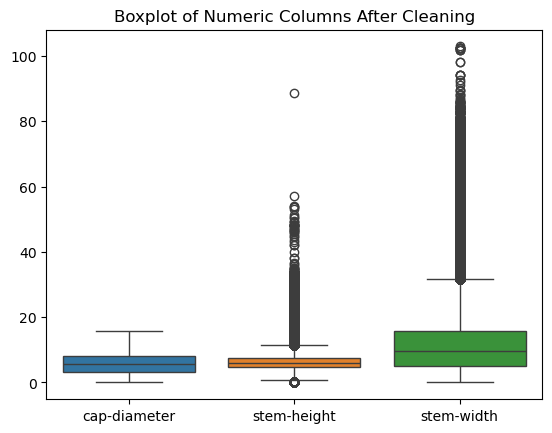

In [6]:
sns.boxplot(data=XTrain[NumericCols])
plt.title("Boxplot of Numeric Columns After Cleaning")
plt.show()

# Part 4: Encoding and Feature Engineering

In [5]:
# Combine Datasets for Preprocessing
combined_data = pd.concat([XTrain, CompTest], keys=['train', 'test'])

# Encode categorical columns
OHC = OrdinalEncoder()
OHC.fit(combined_data[CategoricalCols])
XTrain_encoded = OHC.transform(XTrain[CategoricalCols])
Test_encoded = OHC.transform(CompTest[CategoricalCols])

# LabelEncoding for the target
YTrain = XTrain["class"].map({'e': 0, 'p': 1})
XTrain = XTrain.drop("class", axis = 1)
   
# Concatenate scaled numeric features with encoded categorical features
XTrain = np.hstack((XTrain_encoded, XTrain[NumericCols]))
CompTest = np.hstack((Test_encoded, CompTest[NumericCols]))

# Visualization 3: Correlation Heatmap

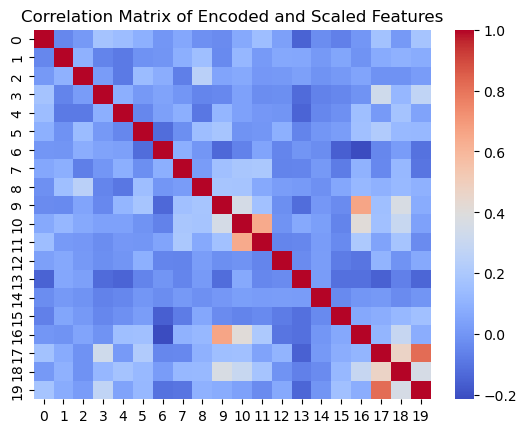

In [8]:
corr = pd.DataFrame(XTrain).corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix of Encoded and Scaled Features")
plt.show()

# Part 5: Train-Test Split and Model Initialization

In [6]:
XTrain, XTest, YTrain, YTest = train_test_split(XTrain, YTrain, test_size = 0.05, random_state = 42)

# XGBoost models initialization
XG = {'n_estimators': 1696,
 'alpha': 4.956752183261538e-07,
 'subsample': 0.7349948172684168,
 'colsample_bytree': 0.30171411525842506,
 'max_depth': 15, 
 'min_child_weight': 6,
 'learning_rate': 0.013301072238797047,
 'gamma': 5.634602153104516e-08
}

xgb_models = [(f"xgb_{i}", XGBClassifier(**XG, random_state=i, tree_method = 'gpu_hist')) for i in range(9)]

# Part 6: Model Training and Evaluation

In [7]:
# Fit models and collect predictions on the validation set
test_pred_probas = []
train_scores = []

for name, model in xgb_models:
    model.fit(XTrain, YTrain)
    train_preds = model.predict(XTest)
    mcc = matthews_corrcoef(YTest, train_preds)
    print(f'Training Data -> Model: {name}, MCC: {round(mcc, 5)}')
    print()
    train_scores.append(mcc)
    test_pred_probas.append(model.predict_proba(XTest)[:, 1])  # Collect predictions on the validation set
    
train_scores_mean = np.mean(train_scores)
print(f'Mean Scores: {train_scores_mean}')
print('Model Fitting Complete')

# Calculate the mean of the validation predictions from all models
mean_test_pred_probas = np.mean(test_pred_probas, axis=0)

# Find the best threshold using validation set predictions and true labels
thresholds = np.arange(0.45, 0.55, 0.005)
best_threshold = 0
best_mcc = -1

for threshold in thresholds:
    y_pred = (mean_test_pred_probas >= threshold).astype(int)
    mcc = matthews_corrcoef(YTest, y_pred)
    if mcc > best_mcc:
        best_mcc = mcc
        best_threshold = threshold

print(f'Best Threshold: {best_threshold}, Best MCC: {best_mcc}')

# Apply the best threshold to the competition test set
comp_test_pred_probas = []
for name, model in xgb_models:
    comp_test_pred_probas.append(model.predict_proba(CompTest)[:, 1])

mean_comp_test_pred_probas = np.mean(comp_test_pred_probas, axis=0)
test_predictions = mean_comp_test_pred_probas > best_threshold

# Prepare the submission
submission = pd.read_csv("/kaggle/input/playground-series-s4e8/sample_submission.csv")
submission["class"] = test_predictions.astype(int)
submission['class'] = submission['class'].map({0: 'e', 1: 'p'})
submission.to_csv('submission.csv', index=False)


Training Data -> Model: xgb_0, MCC: 0.98463

Training Data -> Model: xgb_1, MCC: 0.98468

Training Data -> Model: xgb_2, MCC: 0.98456

Training Data -> Model: xgb_3, MCC: 0.98469

Training Data -> Model: xgb_4, MCC: 0.98476

Training Data -> Model: xgb_5, MCC: 0.98459

Training Data -> Model: xgb_6, MCC: 0.98464

Training Data -> Model: xgb_7, MCC: 0.98465

Training Data -> Model: xgb_8, MCC: 0.9846

Mean Scores: 0.9846445479893988
Model Fitting Complete
Best Threshold: 0.455, Best MCC: 0.9847806253246938


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/playground-series-s4e8/sample_submission.csv'